In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from itertools import groupby
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
import nltk
import lightgbm as lgb

from utils import helper
from utils import DataLoader, DataProcesser

%load_ext autoreload
%autoreload 2

In [2]:
label_dic = {1: 'Still', 2: 'Walking', 3: 'Run', 4: 'Bike', 5: 'Car', 6: 'Bus', 7: 'Train', 8: 'Subway'}

# Routine PipLines

In [3]:
col_drop_x = ['time', 'label']
col_label = 'label'
col_drop = ['latitude',
 'longitude',
 'altitude',
 'time_dlt',
 'valid_dlt',
 'east',
 'north',
 'east_dlt',
 'north_dlt',
 'east_speed',
 'north_speed',
 'cells_ctype_mode',
 'speed_dif',
 'speed_dlt',
 'speed'
 ]

In [4]:
data = DataLoader.SHLDataLoader('data/train/', ratio = None)
val = DataLoader.SHLDataLoader('data/validate/', ratio = None)
data.df = pd.read_csv('data/mid_res/20210526_data_df.csv')
val.df = pd.read_csv('data/mid_res/20210526_val_df.csv')

In [5]:
test_ratio = 0.2
col_label = 'label'
X = data.df.drop(col_drop + col_drop_x, axis = 1).fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X, data.df[col_label], test_size = test_ratio)
X_val, y_val = val.df.drop(col_drop + col_drop_x, axis = 1).fillna(0), val.df[col_label]

In [6]:
model_rf = RandomForestClassifier(n_estimators = 20, random_state = 0, max_depth = 8)
model_rf.fit(X_train, y_train)
pred_rf = model_rf.predict(X_val)
pred_prob_rf = model_rf.predict_proba(X_val)

In [7]:
model_bag = BaggingClassifier(DecisionTreeClassifier(), n_estimators = 100, max_samples = 100, bootstrap=True)
model_bag.fit(X_train, y_train)
pred_bag = model_bag.predict(X_val)
pred_prob_bag = model_bag.predict_proba(X_val)

In [8]:
train_data = lgb.Dataset(X_train, label = y_train - 1)
test_data = lgb.Dataset(X_val, label = y_val - 1)
params={
    'learning_rate':0.1,
    'lambda_l1':0.1,
    'lambda_l2':0.2,
    'max_depth':6,
    'objective':'multiclass',
    'num_class':8,  
}
model_lgb = lgb.train(params, train_data, valid_sets = [test_data])
pred_prob_lgb = model_lgb.predict(X_val)
pred_lgb = pred_prob_lgb.argmax(axis = 1) + 1

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015614 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5017
[LightGBM] [Info] Number of data points in the train set: 784421, number of used features: 32
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score -2.081980
[LightGBM] [Info] Start training from score -2.076068
[LightGBM] [Info] Start training from score -3.143894
[LightGBM] [Info] Start training from score -2.121970
[LightGBM] [Info] Start training from

In [9]:
# helper.evaluate(pred_rf, y_val)

---
# Post Process - Discrete

In [10]:
# pred = pd.Series(pred_rf)
# pred_prob = pred_prob_rf

In [19]:
def get_pred_mode(sr):
    ct = Counter(sr).most_common()[0]
    return ct[0] if ct[1] >= 2 else sr[2]

df_res = pd.DataFrame({"rf": pred_rf, "bag": pred_bag, "lgb": pred_lgb})
df_res['pred'] = df_res.apply(lambda x: get_pred_mode(x[['rf', 'bag', 'lgb']]), axis = 1)
df_res['pred_mode'] = df_res['pred'].rolling(90, center = True).agg(lambda x: x.mode()[0]).fillna(method = 'ffill').fillna(method = 'bfill').astype('int')

In [20]:
pred = df_res['pred_mode']

In [21]:
def plot_prediction(y_pred, y_true):
    plt.figure(figsize = [20, 8])
    plt.plot(y_pred, alpha = 0.4)
    plt.plot(y_true)

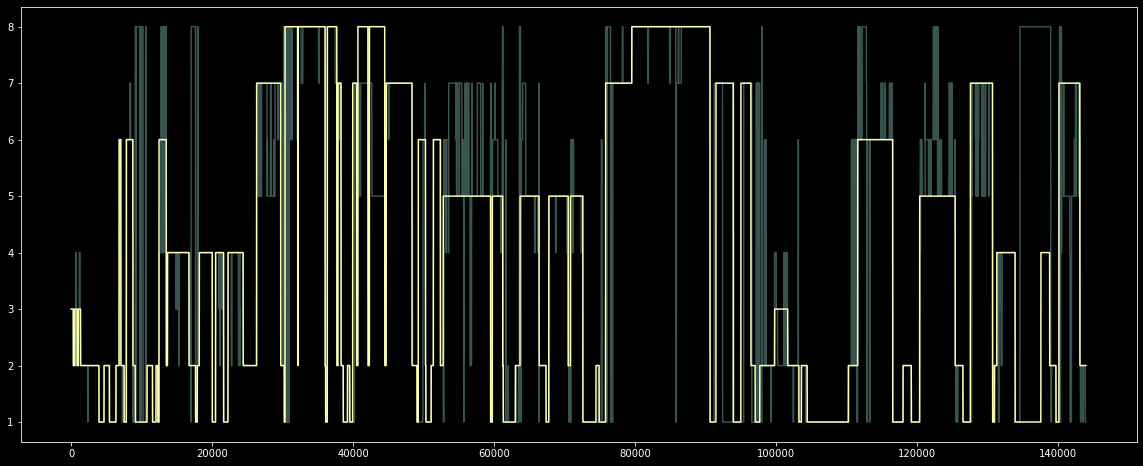

In [22]:
plot_prediction(pred, y_val)

[[24676  3357     0   115   340   877  3024   507]
 [  254 19685  1578   568   332     2    39    17]
 [    0    19   738   470     0     0     0     0]
 [   23    89   458  9633   771   588    59     0]
 [    0   209     0     0 11302     0  3929  2039]
 [  114   984     0     0  3706  5618   740    74]
 [  694   703     0     0  3473   792 13191  2891]
 [ 4075  1103     0  1245   549  1301   826 16181]]
              precision    recall  f1-score   support

       Still       0.83      0.75      0.79     32896
     Walking       0.75      0.88      0.81     22475
         Run       0.27      0.60      0.37      1227
        Bike       0.80      0.83      0.81     11621
         Car       0.55      0.65      0.60     17479
         Bus       0.61      0.50      0.55     11236
       Train       0.60      0.61      0.61     21744
      Subway       0.75      0.64      0.69     25280

    accuracy                           0.70    143958
   macro avg       0.65      0.68      0.65    14

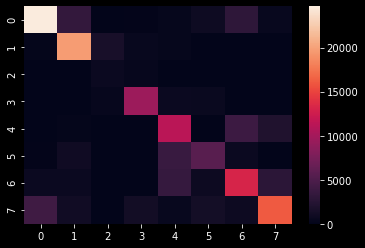

In [23]:
helper.evaluate(pred, y_val)

---
# Post Process - Continuous

- Add + mean + argmax
- Mean + add + argmax

In [24]:
# Add + mean + argmax
pred_prob = pred_prob_rf + pred_prob_bag + pred_prob_lgb
pred_prob_mean = pd.DataFrame(pred_prob).rolling(100, center = True).mean().fillna(method = 'ffill').fillna(method = 'bfill')
pred_mean = pd.Series(np.array(pred_prob_mean).argmax(axis = 1) + 1)

[[23830  3209     0   136   283   756  2968   502]
 [ 1289 19607  1039   657   462    19    47   107]
 [    0    11   606   509     0     0     0     0]
 [   20    45  1129  9484   747    46    43     0]
 [    3   270     0     0 11334     0  3937   215]
 [  129  1382     0     0  3749  5715   399    58]
 [  781   647     0     0  3339  1203 13643  4430]
 [ 3784   978     0  1245   559  1439   771 16397]]
              precision    recall  f1-score   support

       Still       0.80      0.75      0.77     31684
     Walking       0.75      0.84      0.79     23227
         Run       0.22      0.54      0.31      1126
        Bike       0.79      0.82      0.81     11514
         Car       0.55      0.72      0.63     15759
         Bus       0.62      0.50      0.55     11432
       Train       0.63      0.57      0.60     24043
      Subway       0.76      0.65      0.70     25173

    accuracy                           0.70    143958
   macro avg       0.64      0.67      0.65    14

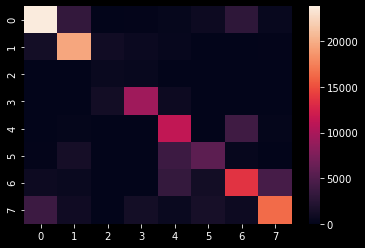

In [25]:
helper.evaluate(pred_mean, y_val)

In [27]:
# Mean + add + argmax
pred_prob_rf_mean = pd.DataFrame(pred_prob_rf).rolling(100, center = True).mean().fillna(method = 'ffill').fillna(method = 'bfill')
pred_prob_bag_mean = pd.DataFrame(pred_prob_bag).rolling(100, center = True).mean().fillna(method = 'ffill').fillna(method = 'bfill')
pred_prob_lgb_mean = pd.DataFrame(pred_prob_lgb).rolling(100, center = True).mean().fillna(method = 'ffill').fillna(method = 'bfill')

pred_prob_mean = pred_prob_rf_mean + pred_prob_bag_mean + pred_prob_lgb_mean
pred_mean2 = pd.Series(np.array(pred_prob_mean).argmax(axis = 1) + 1)


[[23830  3209     0   136   283   756  2968   502]
 [ 1289 19607  1039   657   462    19    47   107]
 [    0    11   606   509     0     0     0     0]
 [   20    45  1129  9484   747    46    43     0]
 [    3   270     0     0 11334     0  3937   215]
 [  129  1382     0     0  3749  5715   399    58]
 [  781   647     0     0  3339  1203 13643  4430]
 [ 3784   978     0  1245   559  1439   771 16397]]
              precision    recall  f1-score   support

       Still       0.80      0.75      0.77     31684
     Walking       0.75      0.84      0.79     23227
         Run       0.22      0.54      0.31      1126
        Bike       0.79      0.82      0.81     11514
         Car       0.55      0.72      0.63     15759
         Bus       0.62      0.50      0.55     11432
       Train       0.63      0.57      0.60     24043
      Subway       0.76      0.65      0.70     25173

    accuracy                           0.70    143958
   macro avg       0.64      0.67      0.65    14

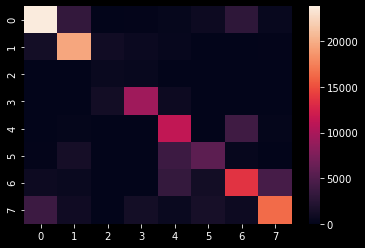

In [28]:
helper.evaluate(pred_mean2, y_val)

In [15]:
pred_prob_mean = pd.DataFrame(pred_prob).rolling(100, center = True).mean().fillna(method = 'ffill').fillna(method = 'bfill')

In [16]:
pred_mean = pd.Series(np.array(pred_prob_mean).argmax(axis = 1) + 1)

[[25159  3925     0   114   427  1090  2951  1199]
 [  142 18072   615   662   154    15    19     0]
 [    0     0   474   272     0     0     0     0]
 [   70    70  1051  9738   584   420   105     0]
 [   16   209     0     0  9289     0  5253  1943]
 [  139  1875   634     0  3995  6105   934   808]
 [ 1183   937     0     0  5254   611 11934  3123]
 [ 3127  1061     0  1245   770   937   612 14636]]
              precision    recall  f1-score   support

       Still       0.84      0.72      0.78     34865
     Walking       0.69      0.92      0.79     19679
         Run       0.17      0.64      0.27       746
        Bike       0.81      0.81      0.81     12038
         Car       0.45      0.56      0.50     16710
         Bus       0.67      0.42      0.52     14490
       Train       0.55      0.52      0.53     23042
      Subway       0.67      0.65      0.66     22388

    accuracy                           0.66    143958
   macro avg       0.61      0.65      0.61    14

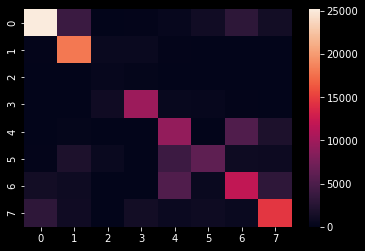

In [17]:
helper.evaluate(pred_mean, y_val)

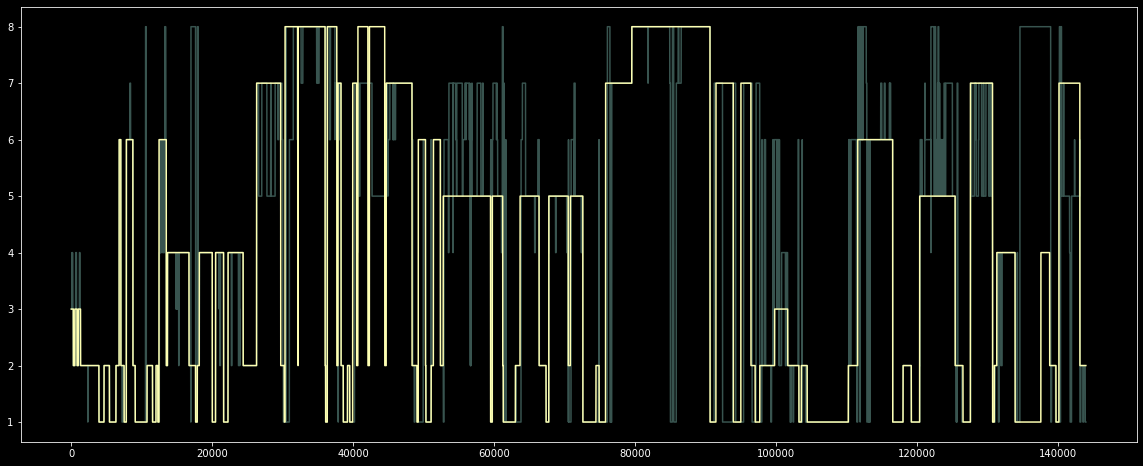

In [18]:
plot_prediction(pred_mean, y_val)

In [19]:
df_tmp = pd.DataFrame({"pred_mode": pred_mode, "pred_mean": pred_mean, "label": y_val})
df_tmp = df_tmp[df_tmp.pred_mode != df_tmp.pred_mean].reset_index(drop = True)

In [20]:
df_tmp['hit2'] = df_tmp.apply(lambda x: int((x['pred_mode'] == x['label']) | (x['pred_mean'] == x['label'])), axis = 1)

In [21]:
Counter(df_tmp['hit2'])

Counter({1: 5205, 0: 1902})

## Rule-Based Method

- Duration Restriction
- Transition Banning

In [306]:
def get_group_conscount(sr):
    groups = groupby(sr.values.tolist())
    grouped_elements = [list(group) for key, group in groups]
    dur_df = pd.DataFrame({"label": [t[0] for t in grouped_elements],
                        "duration": [len(t) for t in grouped_elements]})
    return dur_df

In [307]:
df_dur = get_group_conscount(pred_mode)
df_dur['cons_state_index'] = df_dur.index

In [308]:
df_res = pd.DataFrame({'pred': pred_mode})
df_res['cons_state_index'] = (df_res['pred'].diff(1) != 0).astype('int').cumsum() - 1
df_res = pd.merge(df_res, df_dur, on = 'cons_state_index')

In [309]:
df_res['pred_last'] = df_res['pred'].shift(1).fillna(method = 'bfill').astype('int')

In [310]:
rule_time_dic = dict({1: 30, 2: 10, 3: 30, 4: 30, 5:30, 6: 30, 7: 30, 8: 30})

In [311]:
rule_trans_map = np.array(pd.read_table('data/transition_rule.txt', sep = ',', header = None))

In [312]:
pred_rule = df_res['pred'].copy()
for i in range(df_res.shape[0]):
    if df_res['duration'][i] < rule_time_dic[df_res['pred'][i]]:
        pred_rule[i] = df_res['pred_last'][i]
        df_res['pred_last'][i+1] = pred_rule[i]
    # transition rule
    if rule_trans_map[df_res['pred_last'][i]-1, df_res['pred'][i]-1] == 0:
        pred_rule[i] = df_res['pred_last'][i]
        df_res['pred_last'][i+1] = pred_rule[i]

[[25159  3925     0   114   427  1090  2951  1199]
 [  142 18072   615   662   154    15    19     0]
 [    0     0   474   272     0     0     0     0]
 [   70    70  1051  9738   584   420   105     0]
 [   16   209     0     0  9289     0  5253  1943]
 [  139  1875   634     0  3995  6105   934   808]
 [ 1183   937     0     0  5254   611 11934  3123]
 [ 3127  1061     0  1245   770   937   612 14636]]
              precision    recall  f1-score   support

       Still       0.84      0.72      0.78     34865
     Walking       0.69      0.92      0.79     19679
         Run       0.17      0.64      0.27       746
        Bike       0.81      0.81      0.81     12038
         Car       0.45      0.56      0.50     16710
         Bus       0.67      0.42      0.52     14490
       Train       0.55      0.52      0.53     23042
      Subway       0.67      0.65      0.66     22388

    accuracy                           0.66    143958
   macro avg       0.61      0.65      0.61    14

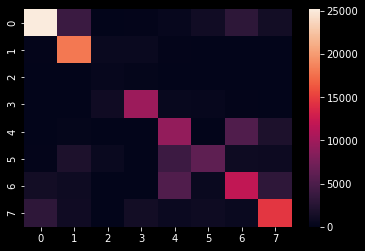

In [313]:
helper.evaluate(pred_mean, y_val)

[[23491  3484     0   158   439  1014  2654   300]
 [  173 16661   633   568   149     1    26     0]
 [    0     0   595   103     0     0     0     0]
 [  103   179   957  9941   697   645    92     0]
 [  168    99     0     0  3214     0  2285     0]
 [  184  1470   589     0 12841  7320     0  6127]
 [ 1108  1290     0     0  3133     0 15780 13888]
 [ 4609  2966     0  1261     0   198   971  1394]]
              precision    recall  f1-score   support

       Still       0.79      0.74      0.77     31540
     Walking       0.64      0.91      0.75     18211
         Run       0.21      0.85      0.34       698
        Bike       0.83      0.79      0.81     12614
         Car       0.16      0.56      0.24      5766
         Bus       0.80      0.26      0.39     28531
       Train       0.72      0.45      0.55     35199
      Subway       0.06      0.12      0.08     11399

    accuracy                           0.54    143958
   macro avg       0.53      0.59      0.49    14

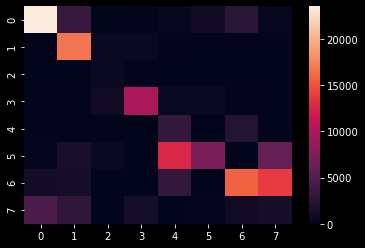

In [314]:
helper.evaluate(pred_rule, y_val)

In [315]:
df_dur2 = get_group_conscount(pred_rule)

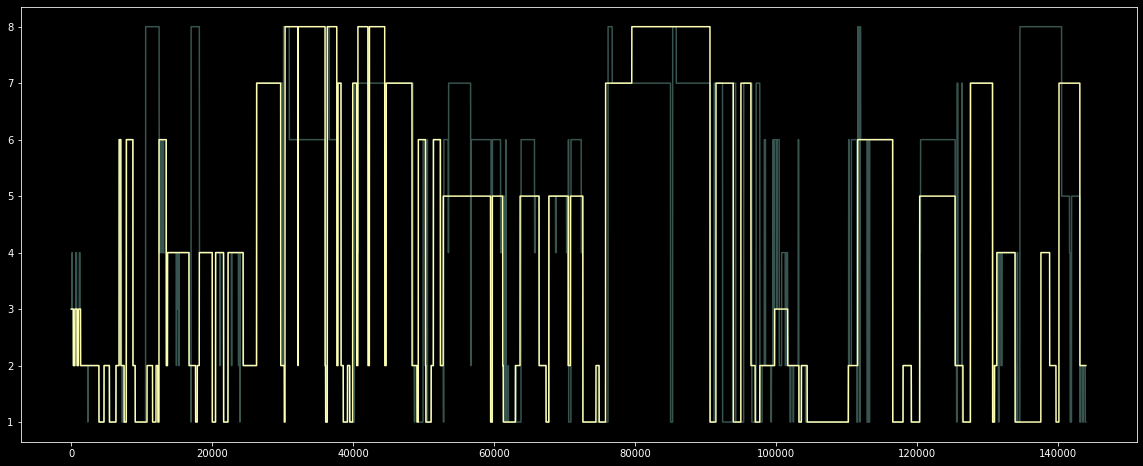

In [316]:
plot_prediction(pred_rule, y_val)

In [317]:
df_dur2.groupby('label').min()

,duration
label,
1,30
2,12
3,61
4,34
5,81
6,32
7,56
8,75


## Transition

In [173]:
tmp = np.zeros([8, 8])
for i, pair in enumerate(nltk.bigrams(data.df[data.df['valid_dlt'] == 1].label)):
    if pair[0] != pair[1]:
        tmp[pair[0]-1, pair[1]-1] += 1
tmp

array([[ 0., 23.,  4., 21.,  8., 45., 32., 23.],
       [60.,  0., 12., 21., 15., 15., 16., 22.],
       [ 8., 11.,  0.,  6.,  6.,  3.,  2.,  0.],
       [28., 23.,  5.,  0.,  6.,  2.,  4.,  0.],
       [ 8., 11.,  7.,  8.,  0.,  0.,  0.,  0.],
       [17., 42.,  7.,  2.,  0.,  0.,  0.,  0.],
       [17., 24.,  0.,  9.,  0.,  3.,  0.,  2.],
       [18., 27.,  1.,  0.,  0.,  0.,  1.,  0.]])

[[1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0]
 [1 1 1 1 1 1 1 0]
 [1 1 1 1 1 0 0 0]
 [1 1 1 1 0 1 0 0]
 [1 1 0 1 0 1 1 1]
 [1 1 1 0 0 0 1 1]]


<AxesSubplot:>

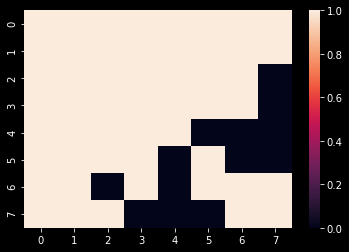

In [215]:
tmp = np.zeros([8, 8])
for i, pair in enumerate(nltk.bigrams(data.df[data.df['valid_dlt'] == 1].label)):
    if pair[0] != pair[1]:
        tmp[pair[0]-1, pair[1]-1] += 1
tmp = 1-(tmp == 0).astype('int') + np.diag([1]*8)
print(tmp)
sns.heatmap(tmp)

<AxesSubplot:>

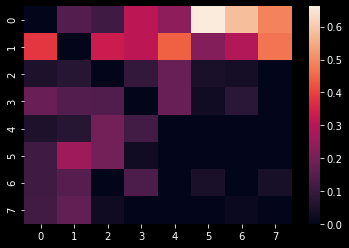

In [146]:
sns.heatmap(tmp / tmp.sum(axis = 1)) # axis = 1 求行和

In [112]:
# plt.figure(figsize = [12, 6])
# sns.boxplot(x = df_dur['label'], y = df_dur['duration'])